In [1]:
from pathlib import Path
from typing import Literal, Callable
from warnings import warn
from itertools import product

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from scipy.ndimage import label

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

from lsst.geom import SpherePoint, Point2I
import lsst.geom as geom
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.afw.math import Warper, WarperConfig
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

In [2]:
service = get_tap_service("tap")

# More on `DetectAndMeasureConfig`

In this notebook we further investigate the configuration of the detection task. First we generate a test image and subtract it.
First let's define a few utilities for running the detection pipeline. 

In [3]:
coord_transient = SkyCoord(
    ra = 56.90063 * u.deg,
    dec = -33.94851 * u.deg, 
    frame='icrs'
)
coord_transient_mag = 17.
band = "r"

In [4]:
def detect(science, template, difference, config: DetectAndMeasureConfig | None = None):
    if config is None:
        config = DetectAndMeasureConfig()
    anomalies = DetectAndMeasureTask(config=config).run(science, template, difference)
    _df = anomalies.getDict()["diaSources"].asAstropy().to_pandas()
    # we don't need much else, so we cut out all other features
    return pd.DataFrame({
        "coord_ra": np.rad2deg(_df["coord_ra"]),
        "coord_dec": np.rad2deg(_df["coord_dec"]),
    })

## 1. The `minPixel` parameter

We investigate the impact of the configuration `minPixel` parameter on the detection pipeline. This parameter should remove anomalies with footprints smaller than its value and could be useful in filtering flukes over single pixels or very small footprints, especially at low threshold. We test over a number of calibrated exposures injected with sources of different magnitude, for different threshold levels. 

In [ ]:
from functools import lru_cache

from doppelganger.doppelganger.rubin.inject import fetch, inject, subtract


def prep_config(threshold, min_pixels):
    config = DetectAndMeasureConfig()
    config.detection.thresholdValue = threshold
    config.detection.minPixels = min_pixels
    return config

# to avoid spending extra time fetching the same image over and over, 
# or fetching possibly different (`fetch` is randomized) images
calexp, template, sources = fetch(service, coord_transient.ra.deg, coord_transient.dec.deg, band)

# we cache over magnitude so that an image get injected only once per magnitude level.
# this optimization will make the simulation much faster 
@lru_cache(maxsize=1)
def sfis_pipeline_cached(mag):
    calexp_injected, calexp_catalog = inject(calexp, coord_transient.ra.deg, coord_transient.dec.deg, mag)
    calexp_difference = subtract(calexp_injected, template, sources)
    return {
        "science": calexp_injected,
        "template": template,
        "difference": calexp_difference,
    }

# simulation imputs
magnitudes = [17, 21, 23, 24, 24.7]
thresholds = [3, 4, 5]
min_pixelss = [1, 4, 16, 64, 128]
params = [*product(magnitudes, thresholds, min_pixelss)]
detections = {(m, t, mp): detect(**sfis_pipeline_cached(m), config=prep_config(t, mp)) for m, t, mp in params}

We analyze the anomalies dataframes and summarize the results in a new table. 

In [10]:
from astropy.coordinates import angular_separation 

def contains_true(anomalies_df):
    return any(
        angular_separation(
            lon * u.deg, 
            lat * u.deg, 
            coord_transient.ra.deg * u.deg, 
            coord_transient.dec.deg * u.deg,
        ) < 1 * u.arcsec
        for i, (lon, lat) in anomalies_df[["coord_ra", "coord_dec"]].iterrows()
    )

ms, ts, mps = zip(*detections.keys())
summary = pd.DataFrame({
    "magnitude": ms,
    "threshold": ts, 
    "min_pixels": mps, 
    "ncandidates": [*map(len, detections.values())], 
    "found_true": [*map(contains_true, detections.values())], 
})
summary

,magnitude,threshold,min_pixels,ncandidates,found_true
0,17.0,3,1,4842,True
1,17.0,3,4,3672,True
2,17.0,3,16,1087,True
3,17.0,3,64,45,True
4,17.0,3,128,26,True
...,...,...,...,...,...
70,24.7,5,1,52,False
71,24.7,5,4,45,False
72,24.7,5,16,29,False
73,24.7,5,64,12,False


### Number of candidates vs `min_pixels`

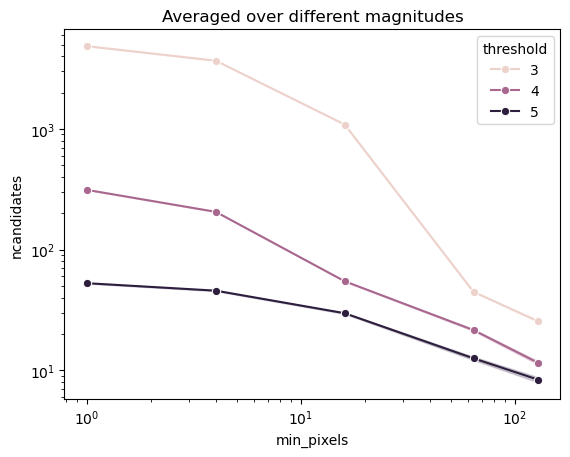

In [11]:
sns.lineplot(summary, x="min_pixels", y="ncandidates", hue="threshold", marker='o', estimator="mean")
plt.loglog()
plt.title("Averaged over different magnitudes")
plt.show()

### Largest `min_pixels` with detection

In [12]:
max_min_pixels = {}
for i, row in summary.iterrows():
    m, t, mp, ft = row[["magnitude", "threshold", "min_pixels", "found_true"]]
    if ft and ((m, t) not in max_min_pixels or max_min_pixels[(m, t)] < mp):
        max_min_pixels[(m, t)] = mp

In [16]:
print("Largest minPixels configuration value with transient detection, as function of simulation parameters:")
for (m, t), Mmp in max_min_pixels.items():
    print(f"magnitude={m}, threshold={t}: {Mmp}")

Largest minPixels configuration value with transient detection, as function of simulation parameters:
magnitude=17.0, threshold=3: 128
magnitude=17.0, threshold=4: 128
magnitude=17.0, threshold=5: 128
magnitude=21.0, threshold=3: 128
magnitude=21.0, threshold=4: 128
magnitude=21.0, threshold=5: 128
magnitude=23.0, threshold=3: 128
magnitude=23.0, threshold=4: 128
magnitude=23.0, threshold=5: 64
magnitude=24.0, threshold=3: 64
magnitude=24.0, threshold=4: 16
magnitude=24.0, threshold=5: 16
magnitude=24.7, threshold=3: 16
